In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import kagglehub
import os

In [2]:
path = kagglehub.dataset_download("alexteboul/diabetes-health-indicators-dataset") # dowloading the dataset from kaggle

In [3]:
file_path = os.path.join(path, 'diabetes_012_health_indicators_BRFSS2015.csv') #accessing the specific file
df = pd.read_csv(file_path) # loading data set in panda data frame

print(df.info()) #Print a summary of the data set


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Diabetes_012          253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   HeartDiseaseorAttack  253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null  float64
 15  

In [4]:
from sklearn.model_selection import train_test_split #necessary to split the data
from sklearn.preprocessing import StandardScaler # Used to scale features

X = df.drop(columns = ['Diabetes_012']) # seperating the features into x and y variables
y = df['Diabetes_012']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # spliting the data for training

# scaling the features
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.transform(X_test)

In [5]:
from imblearn.over_sampling import RandomOverSampler # used to help an imbalance in the dataset

ros = RandomOverSampler(random_state=42) # randomly duplicate minority samples specifically prediabetes
X_resampled, y_resampled = ros.fit_resample(X_train_scaler, y_train) #balanced dataset


In [6]:
# Converting the balanced data to tensors
X_train_tensor = torch.tensor(X_resampled, dtype = torch.float32)
X_test_tensor = torch.tensor(X_test_scaler, dtype = torch.float32)
y_train_tensor = torch.tensor(y_resampled.values, dtype = torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.long)


In [7]:
class DiabetesNet(nn.Module): # MLP
    def __init__(self):
        super(DiabetesNet, self).__init__() #fully connected layers

        self.fc1 = nn.Linear(X_train_tensor.shape[1], 64)
        self.fc2 = nn.Linear(64, 32) #64 to 32 hidden units
        self.fc3 = nn.Linear(32, 16) #32 to 16 hidden units
        self.fc4 = nn.Linear(16, 3) #16 to 3 output units for 3 classes
        self.dropout = nn.Dropout(0.5) #regularazation

    def forward(self, z): #forward pass
        z = F.relu(self.fc1(z))
        z = self.dropout(z)
        z = F.relu(self.fc2(z))
        z = self.dropout(z)
        z = F.relu(self.fc3(z))
        z = self.fc4(z)
        return F.log_softmax(z, dim = 1) # log softmax function
model = DiabetesNet() # creating the model

In [8]:
#weights for imbalance
class_count = np.bincount(y_resampled)
class_weights = 1.0 / torch.tensor(class_count, dtype=torch.float32)

criterion = nn.CrossEntropyLoss(weight=class_weights) #setting up the CrossEntropy function

In [9]:
optimizer = optim.Adam(model.parameters(), lr = 0.01) #Adam optimizer for training

In [10]:
from sklearn.metrics import accuracy_score, classification_report # necessary for a report on the neural models metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # necessary to create a Confusion matrix


def train_model(model, X_train, y_train, criterion, optimizer, num_epochs = 30): # function to train the model
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs): # loop
      model.train() # training the model
      optimizer.zero_grad() # reset the gradients
      output = model(X_train) #forward pass
      loss = criterion(output, y_train) #training loss
      loss.backward() #backpropagation
      optimizer.step() #updating weights

      train_losses.append(loss.item()) # necessary to graph the trainingloss



      model.eval() # test data evaulation
      with torch.no_grad():

        y_pred = model(X_test_tensor) #forward pass
        probabilities = torch.exp(y_pred) # converting log probablilites
        _, predicted = torch.max(probabilities, 1) #predicted class
        accuracy = accuracy_score(y_test_tensor, predicted) #accuracy of testing
        output_test = model(X_test_tensor) #store the test to compute the loss
        loss_test = criterion(output_test, y_test_tensor) # computing the loss
        test_losses.append(loss_test.item()) #necessary to graph the testloss

    print(f'Test Accuracy: {accuracy * 100:.2f}%')

    #plotting training and test losses
    fig, ax = plt.subplots()
    ax.plot(train_losses, label='Train Loss')
    ax.plot(test_losses, label='Test Loss')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.set_title('Train and Test Loss')
    ax.legend()
    plt.show()


    #necessary to plot a report of the classes
    report_graph = pd.DataFrame(classification_report(y_test_tensor, predicted, output_dict=True)).transpose()

    plt.figure(figsize=(10, 6))
    plt.bar(report_graph.index, report_graph['f1-score'])
    plt.xlabel('Classes')
    plt.ylabel('F1-Score')
    plt.title('F1-Score per Class')

    #confusion matrix plot
    cm = confusion_matrix(y_test_tensor, predicted)
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1, 2])
    disp.plot()
    plt.show()




Test Accuracy: 61.67%


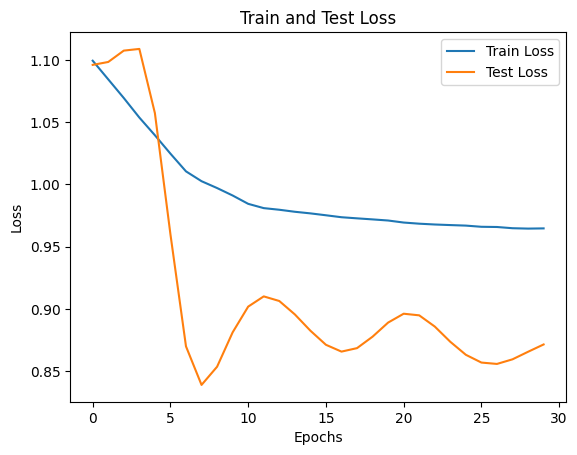

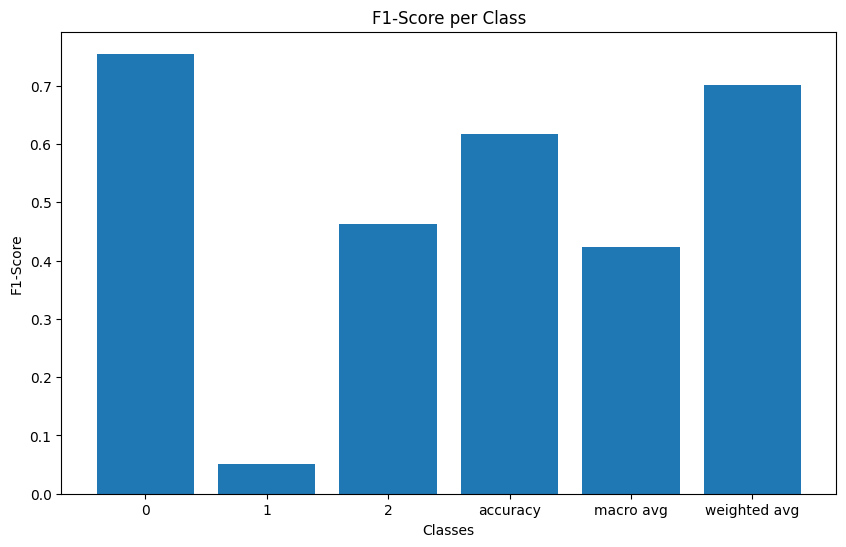

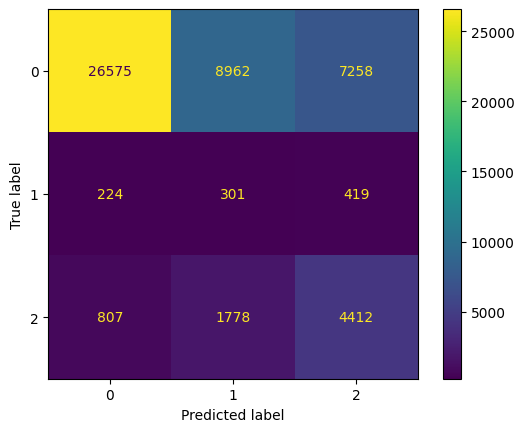

In [11]:
train_model(model, X_train_tensor, y_train_tensor, criterion, optimizer) # call the function to train the model